# Near-Surface Air Temperature

## Test analyse 'tas' avec Intake
Environnement `ciclad_v0` in `/home/mlalande/notebooks/envs/ciclad`


- **[Building identical conda environments](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#building-identical-conda-environments)**:
```bash
conda create --name myenv --file conda_v0.txt  
```

- Or with the .yml: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment


In [8]:
# To reload external files automatically (not needed here)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import intake
from dask.distributed import Client
client = Client()
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://127.0.0.1:39853 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 17.18 GB


## Set variables

In [10]:
period = slice('1979','2014')
var = 'tas'

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49296 remote=tcp://127.0.0.1:8787>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49298 remote=tcp://127.0.0.1:8787>


## Load model data (with Intake)

In [11]:
# Get the catalog
url = "/thredds/ipsl/glipsl/ESPRI-CMIP6-test-collection.json"
cat = intake.open_esm_datastore(url)
cat

,unique
activity_id,16
institution_id,32
source_id,63
experiment_id,101
member_id,4382
table_id,39
variable_id,1029
grid_label,11
time_range,32326
path,2451002


In [13]:
# Get subset of the catalog IPSL CMIP6 historical
cat_IPSL = cat.search(
    experiment_id="historical",
    table_id="Amon",
    variable_id=var,
    source_id="IPSL-CM6A-LR"
)

cat_IPSL

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,32
table_id,1
variable_id,1
grid_label,1
time_range,1
path,32


In [15]:
cat_IPSL.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,time_range,path
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Amon,tas,gr,185001-201412,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r11i1p1f1,Amon,tas,gr,185001-201412,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...
2,CMIP,IPSL,IPSL-CM6A-LR,historical,r12i1p1f1,Amon,tas,gr,185001-201412,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...
3,CMIP,IPSL,IPSL-CM6A-LR,historical,r13i1p1f1,Amon,tas,gr,185001-201412,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...
4,CMIP,IPSL,IPSL-CM6A-LR,historical,r14i1p1f1,Amon,tas,gr,185001-201412,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...


In [16]:
cat_IPSL.keys()

['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

In [17]:
# Get the data to dask arrays (nothing is loaded here, only pointers are created)
ds = cat_IPSL[cat_IPSL.keys()[0]].to_dask()

In [21]:
# Visualize the dask array with the chunks 
# Here the chunks are automatically done on members
# For doing time average it's good, but for the ensemble mean it's better to rechunk
# The data are not too big here (1GB) so we actually don't really need dask
# But it's for the example
ds.tas.sel(time=period).data

dask.array<getitem, shape=(32, 432, 143, 144), dtype=float32, chunksize=(1, 432, 143, 144), chunktype=numpy.ndarray>

### Compute the climatology
For loading and computing the data we need to use `.compute()`, otherwise if we need to do a lot of computation on the data and if it fits in memory the best is to do a `.load()` earlier so that so data will be loaded once and all the next computation will get faster. Here with the `.compute()` dask will load and compute in parallel and once it's done it won't keep anything in memomry (except the result that we store in the variable `clim`).

In [22]:
clim = ds.tas.sel(time=period).mean('time').compute()

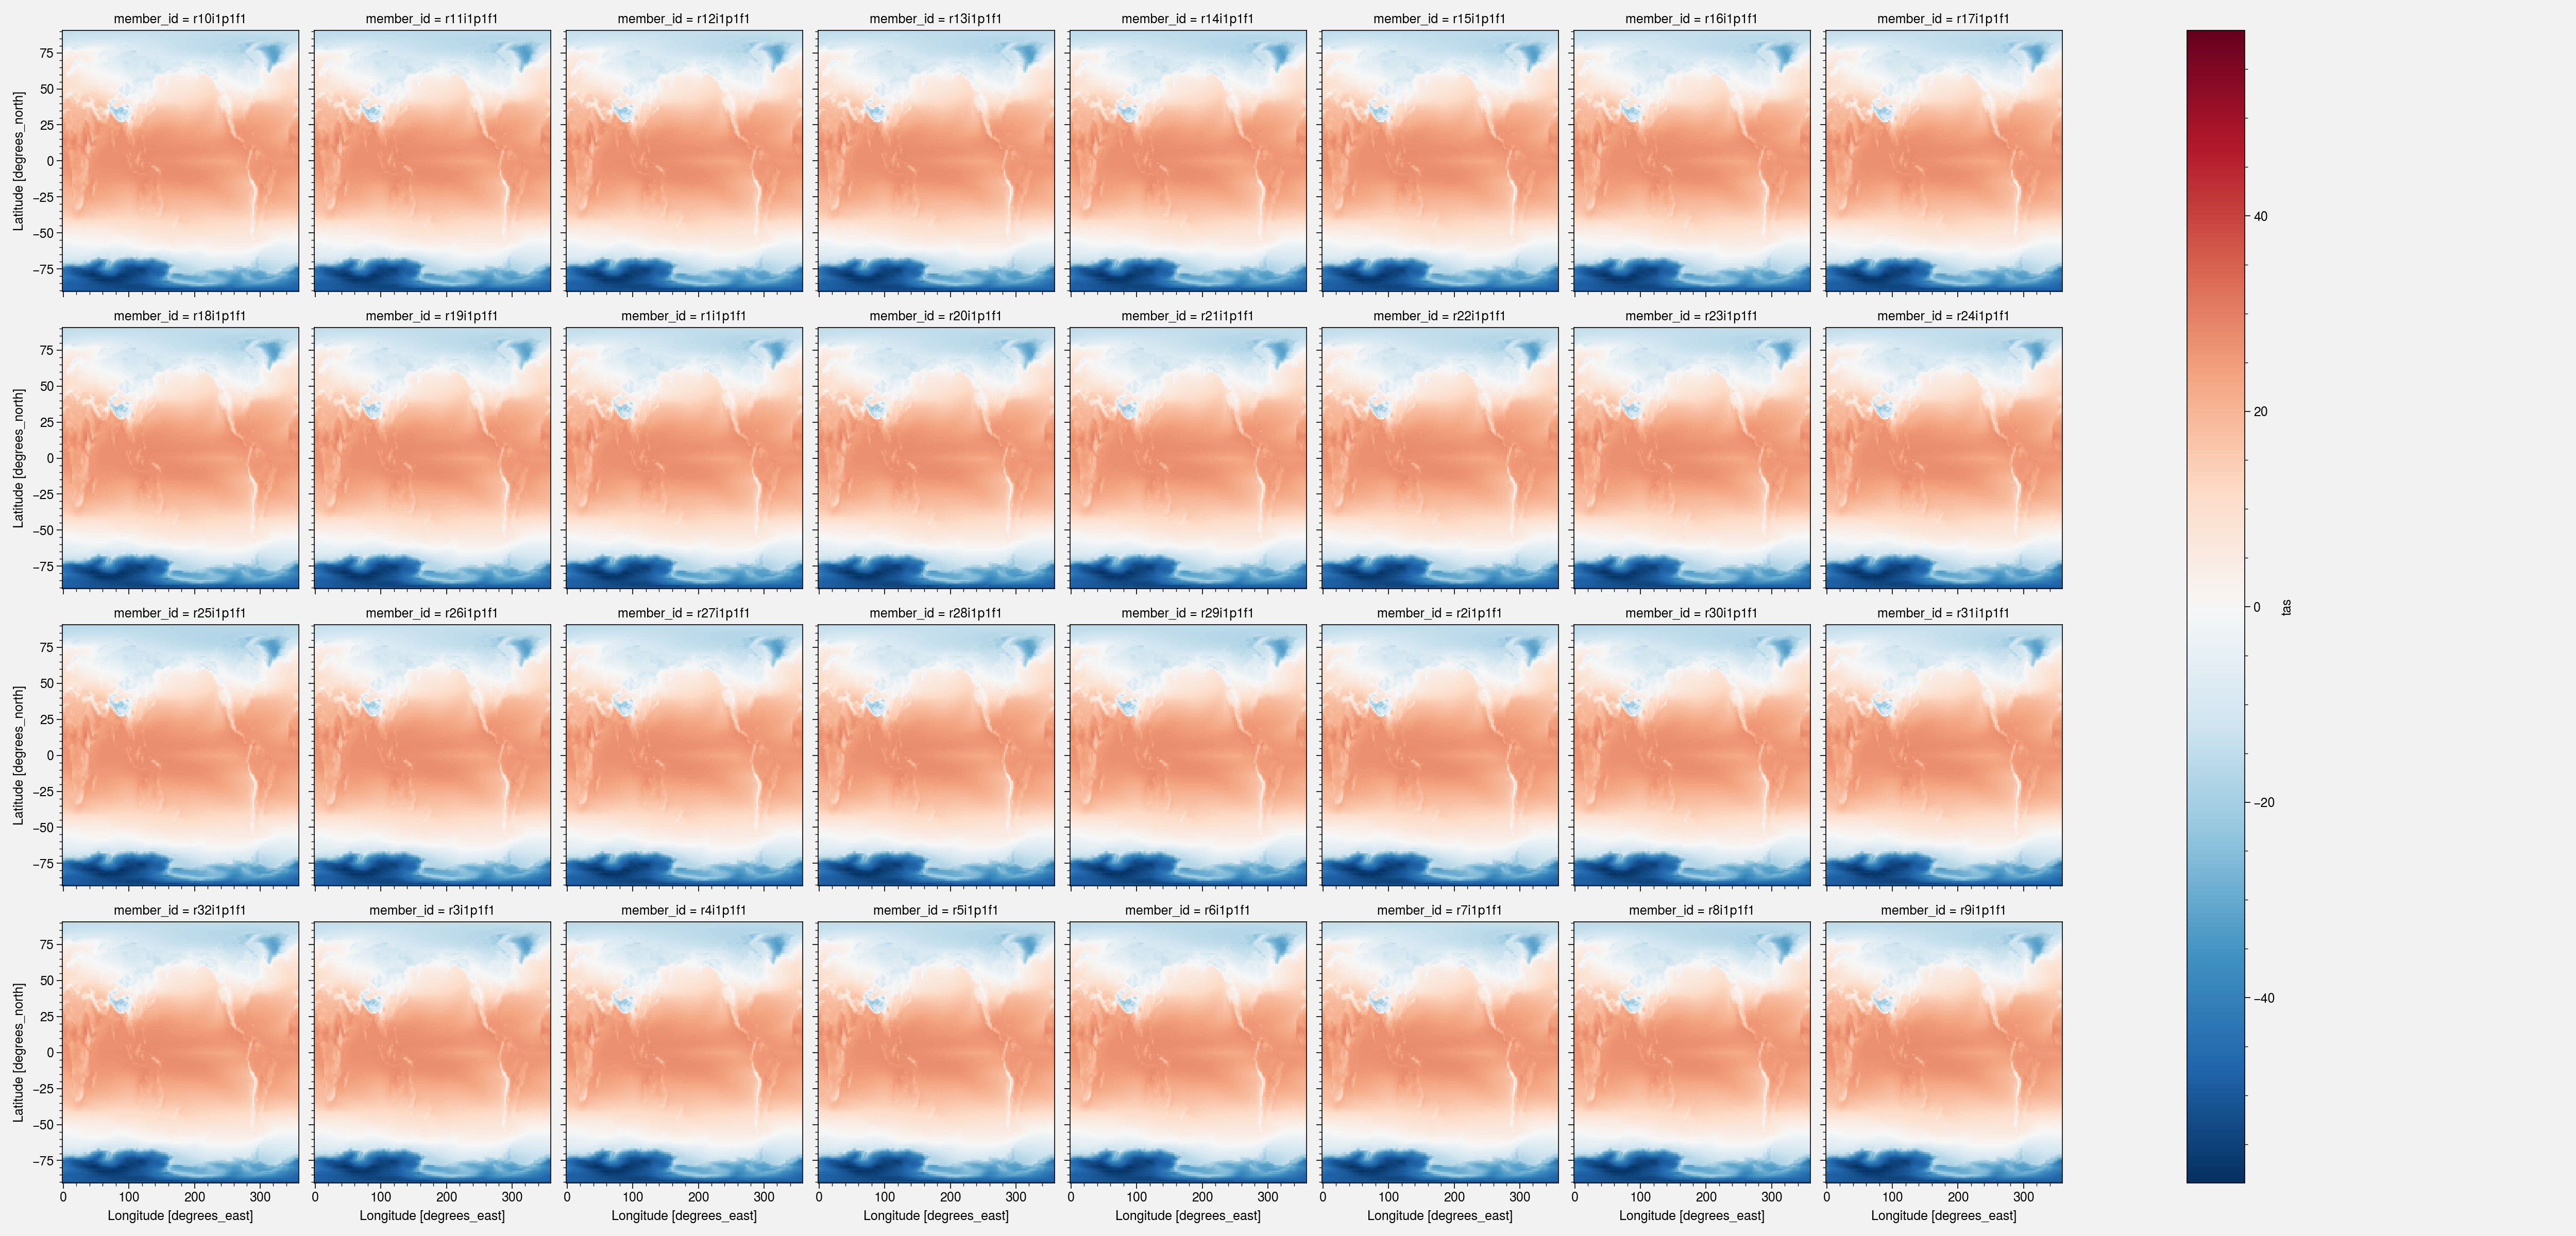

In [25]:
(clim - 273.15).plot(col='member_id', col_wrap=8)

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [27]:
obs = xr.open_dataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc'
).sel(time=period).tmp.mean('time')

/data/mlalande/miniconda3/envs/ciclad_v0/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


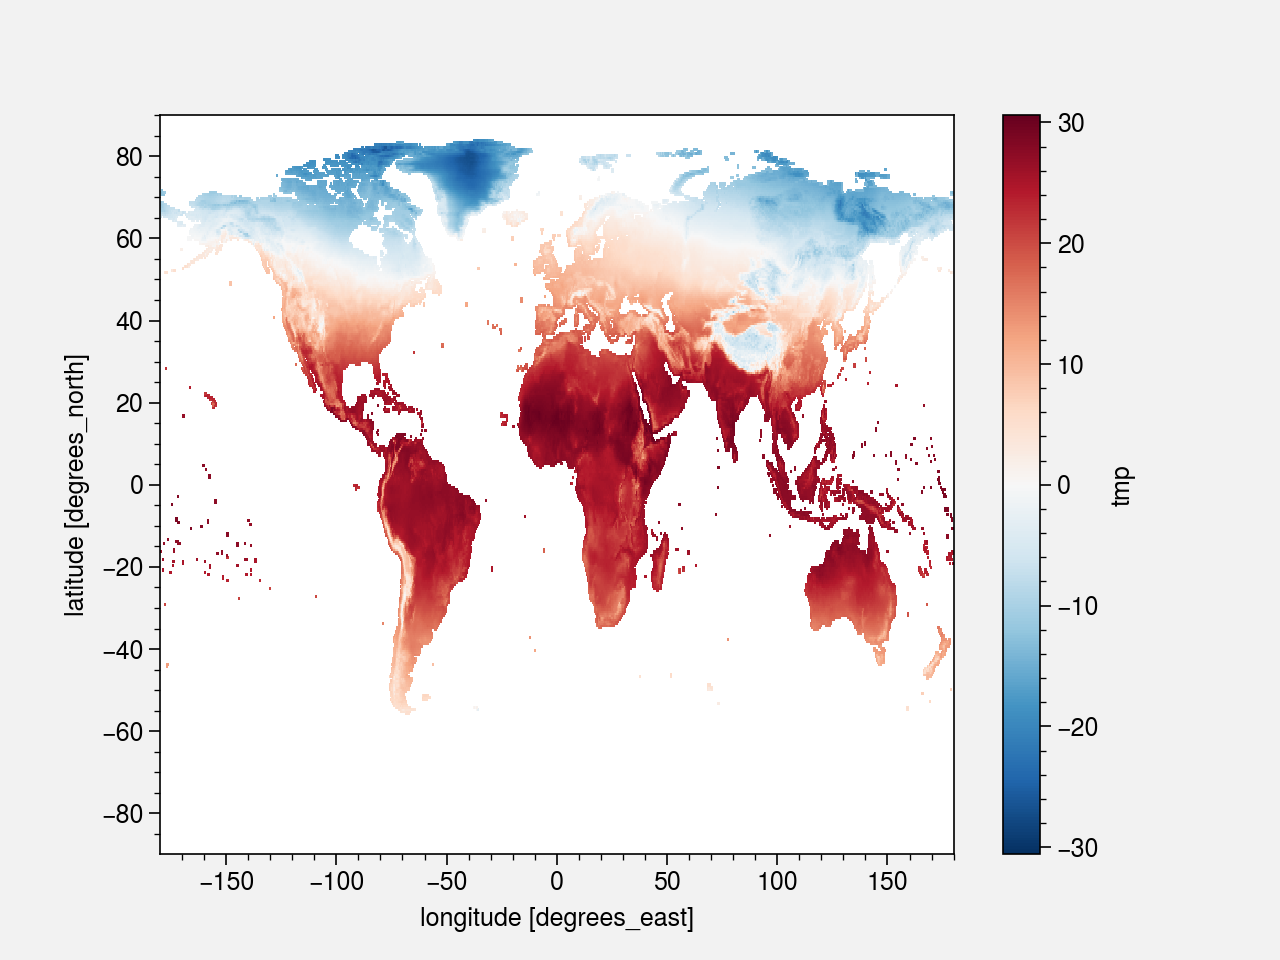

In [28]:
obs.plot()

## Regrid obs towards the model
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [29]:
regridder = xe.Regridder(obs, clim, 'bilinear', periodic=True, reuse_weights=True)
obs_regrid = regridder(obs)

Create weight file: bilinear_360x720_143x144_peri.nc


In [ ]:
# I take this out for github that doesn't show it well
# But great to visualyze data with the new xarray html

# obs_regrid

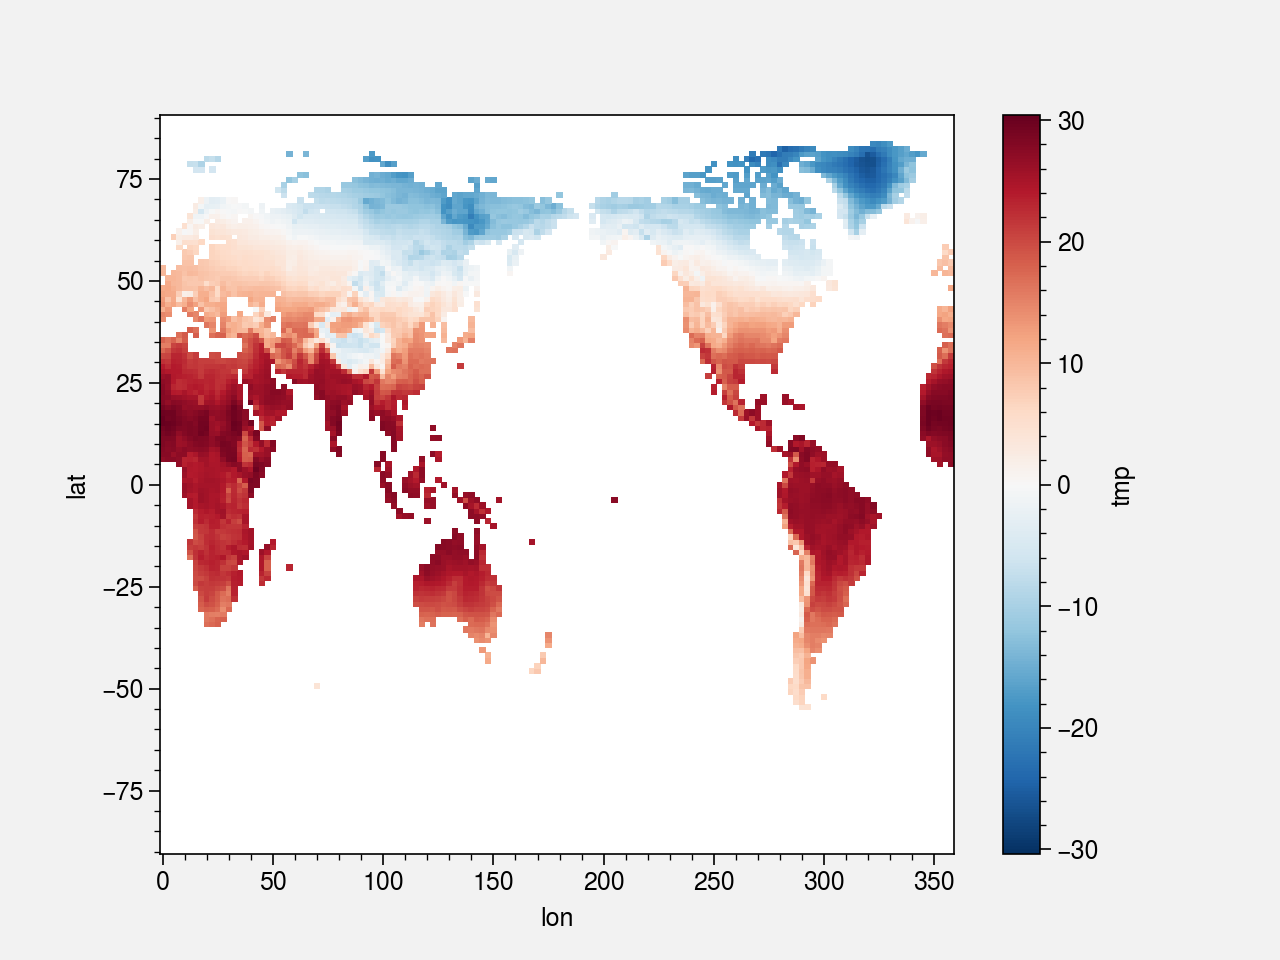

In [31]:
obs_regrid.plot()

## Compare obs to ensemble mean

In [35]:
# Compute ensemble mean
em = clim.mean('member_id') - 273.15

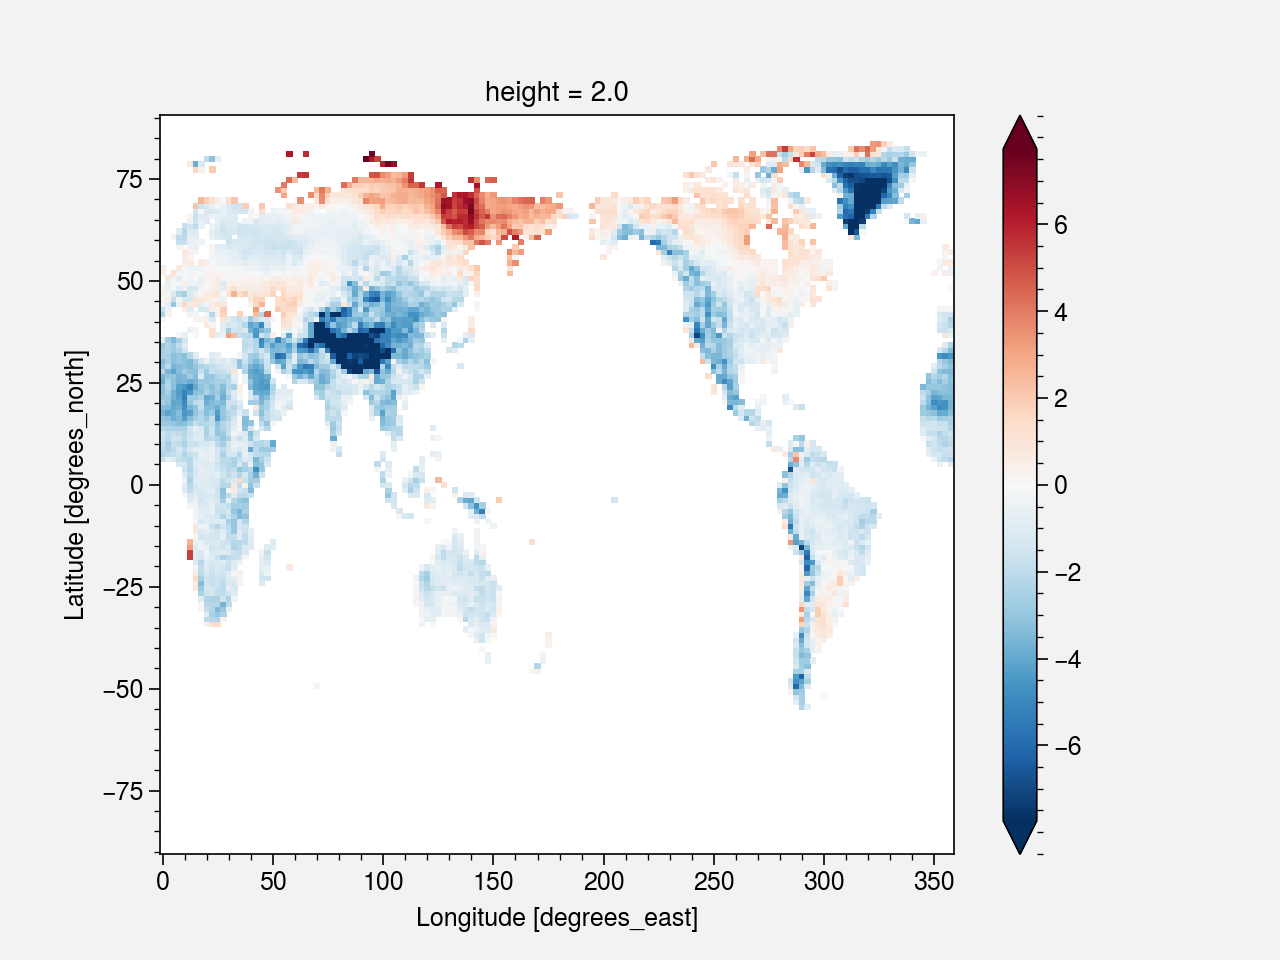

In [45]:
# Check plot
(em - obs_regrid).plot(robust=True)

In [48]:
ds.tas.attrs

{'online_operation': 'average',
 'cell_methods': 'area: time: mean',
 'interval_operation': '900 s',
 'interval_write': '1 month',
 'standard_name': 'air_temperature',
 'description': 'Near-Surface Air Temperature',
 'long_name': 'Near-Surface Air Temperature',
 'history': 'none',
 'units': 'K',
 'cell_measures': 'area: areacella'}

/data/mlalande/miniconda3/envs/ciclad_v0/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


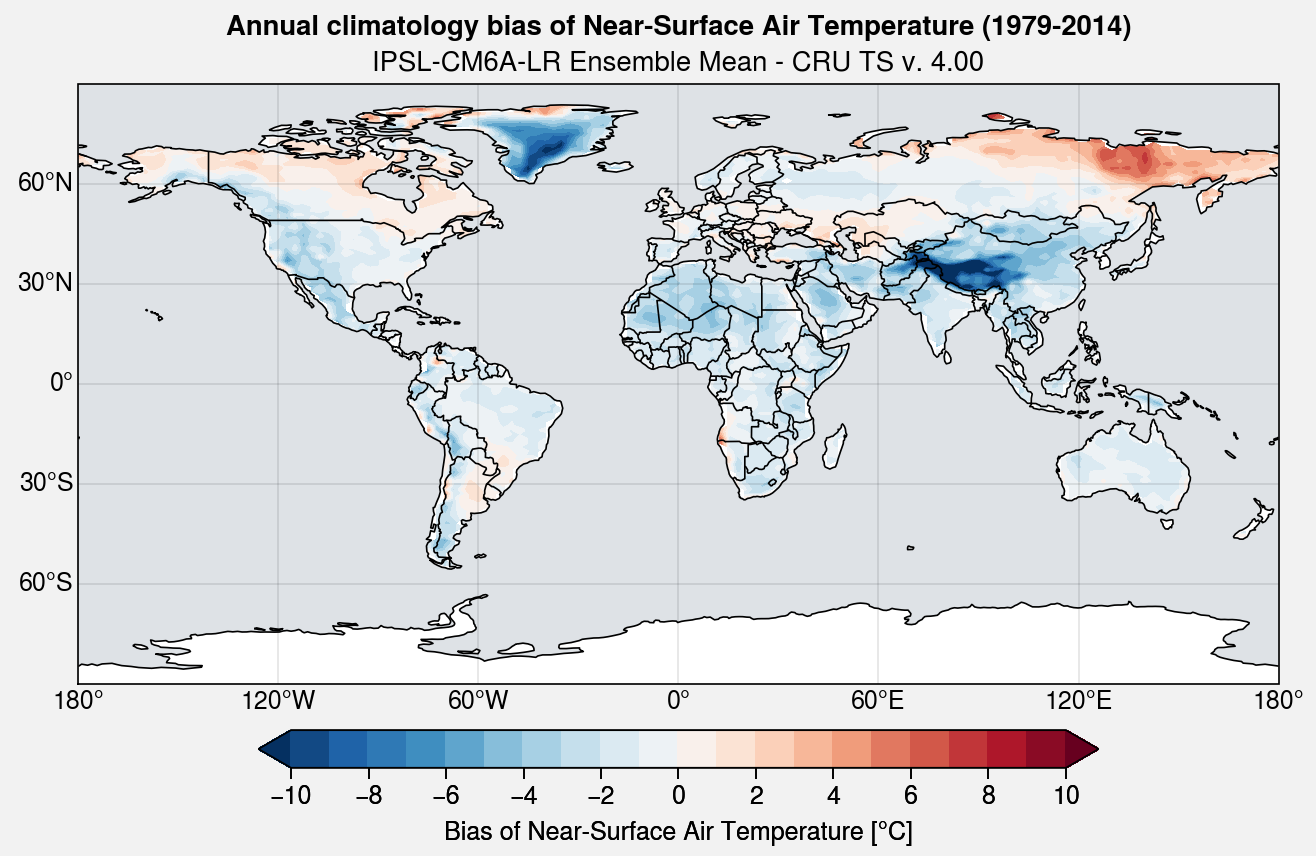

In [70]:
# Proplot plot
f, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=6)

ax = axs[0]

m = ax.contourf(
    em - obs_regrid, 
    levels=plot.arange(-10,10,1), 
    extend='both', 
    cmap='BuRd',
    globe=True # Fill the cycle point
)

ax.colorbar(m, label='Bias of ' + ds.tas.attrs['long_name'] + ' [°C]', loc='b', length=0.7)

axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Annual climatology bias of '+ds.tas.attrs['long_name']+' ('+period.start+'-'+period.stop+')',
    title='IPSL-CM6A-LR Ensemble Mean - CRU TS v. 4.00'
)

filename = 'annual_clim_bias_'+var+'_'+period.start+'-'+period.stop
f.save(filename+'.jpg') # Proplot automatically save with a good dpi

In [71]:
# Close the dask client
client.close()